## Marriage Trends in India

## Import Python Libraries and Data

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

data = pd.read_csv('marriage_data_india.csv')
display(data.head())

,ID,Marriage_Type,Age_at_Marriage,Gender,Education_Level,Caste_Match,Religion,Parental_Approval,Urban_Rural,Dowry_Exchanged,Marital_Satisfaction,Divorce_Status,Children_Count,Income_Level,Years_Since_Marriage,Spouse_Working,Inter-Caste,Inter-Religion
0,1,Love,23,Male,Graduate,Different,Hindu,No,Urban,No,Medium,Yes,5,Middle,34,No,No,No
1,2,Love,28,Female,School,Same,Hindu,Yes,Rural,Yes,Low,No,3,Middle,42,No,No,Yes
2,3,Arranged,39,Male,Postgraduate,Same,Muslim,Yes,Rural,No,Medium,No,0,High,25,No,No,No
3,4,Arranged,26,Female,School,Different,Hindu,Yes,Urban,Yes,Low,No,0,High,12,No,Yes,No
4,5,Love,32,Female,Graduate,Same,Hindu,Partial,Rural,Yes,Medium,No,1,Middle,41,No,No,Yes


## Check for Null Values Within the Entire Dataset

In [49]:
display(data.isna().sum())

,0
ID,0
Marriage_Type,0
Age_at_Marriage,0
Gender,0
Education_Level,0
Caste_Match,0
Religion,0
Parental_Approval,0
Urban_Rural,0
Dowry_Exchanged,0


## Do Some Initial Data Cleaning

In [50]:
data.rename(columns={'Inter-Caste':'Inter_Caste', 'Inter-Religion': 'Inter_Religion'}, inplace=True)
data.drop(columns=['ID'], inplace=True)

## Separate the Column Labels by Numeric and Categorical Data

In [51]:
cols_categorical = data.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical Columns:\n{cols_categorical}")

cols_numeric = data.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numeric Columns:\n{cols_numeric}")

Categorical Columns:
['Marriage_Type', 'Gender', 'Education_Level', 'Caste_Match', 'Religion', 'Parental_Approval', 'Urban_Rural', 'Dowry_Exchanged', 'Marital_Satisfaction', 'Divorce_Status', 'Income_Level', 'Spouse_Working', 'Inter_Caste', 'Inter_Religion']
Numeric Columns:
['Age_at_Marriage', 'Children_Count', 'Years_Since_Marriage']


## Graph the Basic Counts of the Data

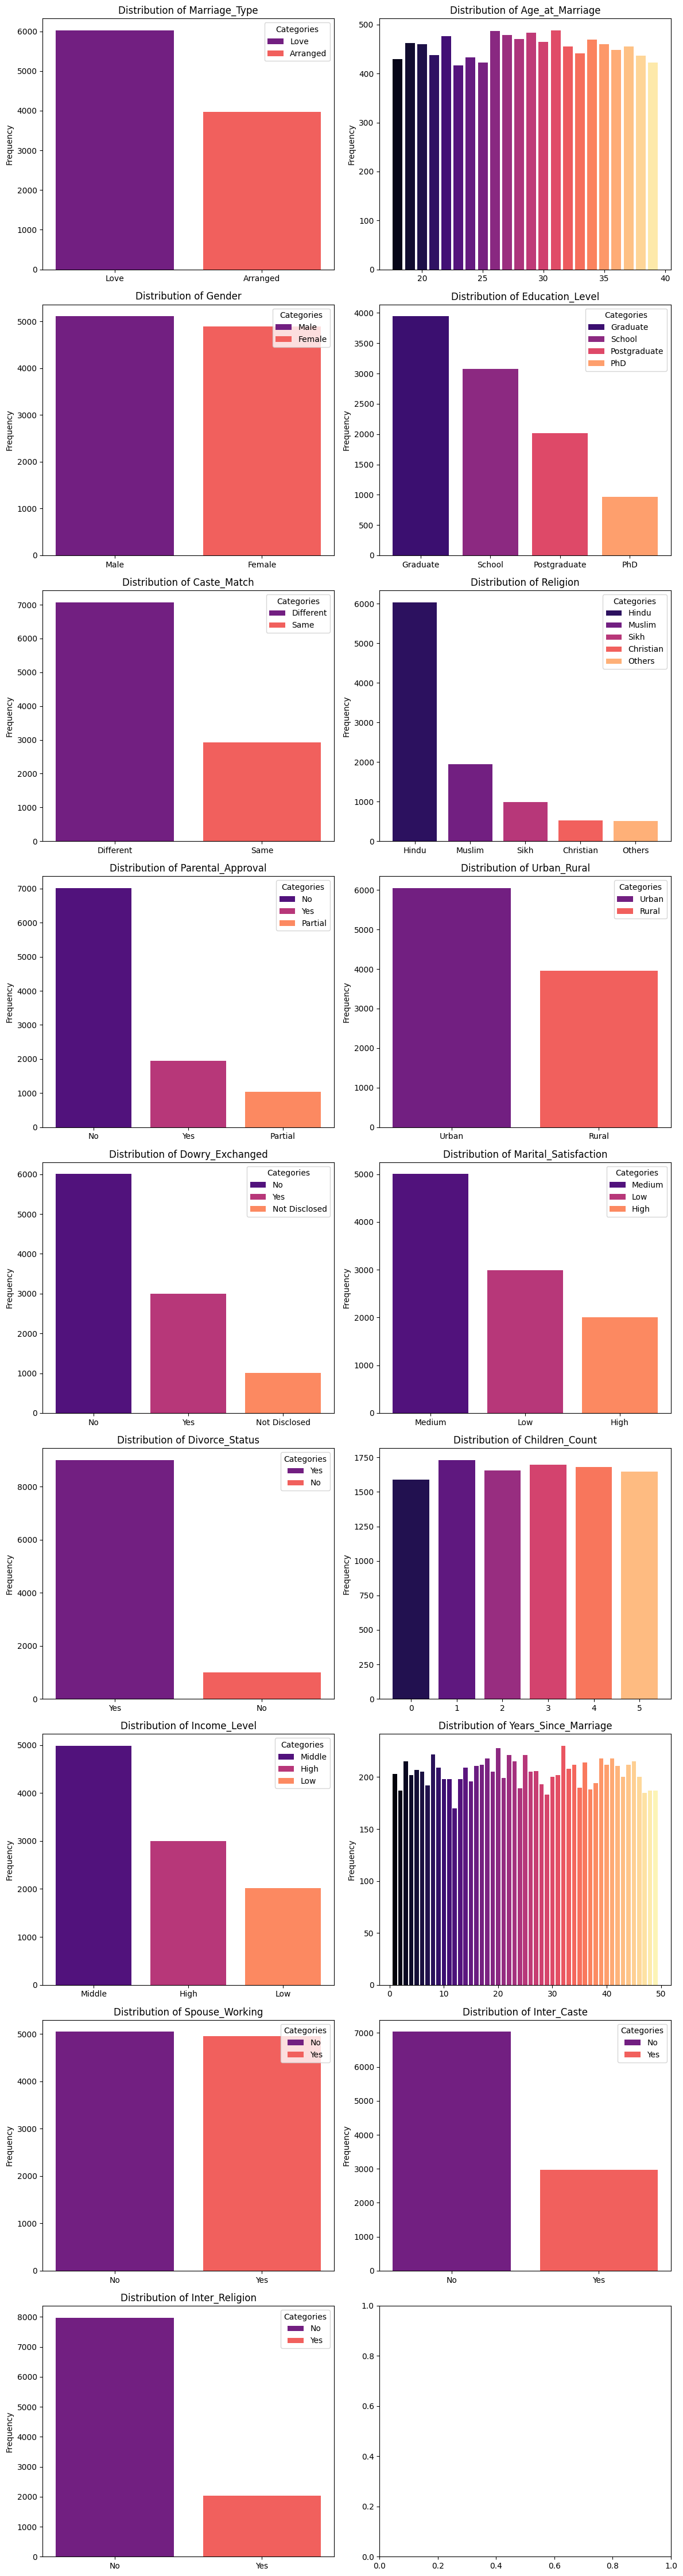

In [52]:
fig, axes = plt.subplots(nrows=(len(data.columns) + 1) // 2, ncols=2, figsize=(12, 5 * ((len(data.columns) + 1) // 2)))
axes = axes.flatten()
for i, col in enumerate(data.columns):
    ax = axes[i]
    x_cats = data[col].unique()
    if col in cols_numeric:
        x_cats = np.sort(x_cats)
        y_counts = data[col].value_counts().sort_index()
    else:
        y_counts = data[col].value_counts()
        colors = sns.color_palette('magma', len(y_counts))
    colors = sns.color_palette('magma', len(y_counts))
    ax.bar(x_cats, y_counts, color=colors, label=x_cats)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {col}')
    if not col in cols_numeric:
        ax.legend(x_cats, title='Categories')
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted()).expanded(1.3, 1.25)
    fig.savefig(f'{col}_Distribution.png', bbox_inches=extent)
plt.tight_layout()
plt.savefig('All_Distributions.png')
plt.show()

## Separate the Data Out to $X$ and $y$ Variables

In [53]:
X = data.drop(columns=['Divorce_Status'])
y = data['Divorce_Status']

## One Hot Encode the Categorical Columns

In [54]:
cols_categorical.remove('Divorce_Status')
X = pd.get_dummies(X, columns=cols_categorical, drop_first=True)
display(X.head())

,Age_at_Marriage,Children_Count,Years_Since_Marriage,Marriage_Type_Love,Gender_Male,Education_Level_PhD,Education_Level_Postgraduate,Education_Level_School,Caste_Match_Same,Religion_Hindu,Religion_Muslim,Religion_Others,Religion_Sikh,Parental_Approval_Partial,Parental_Approval_Yes,Urban_Rural_Urban,Dowry_Exchanged_Not Disclosed,Dowry_Exchanged_Yes,Marital_Satisfaction_Low,Marital_Satisfaction_Medium,Income_Level_Low,Income_Level_Middle,Spouse_Working_Yes,Inter_Caste_Yes,Inter_Religion_Yes
0,23,5,34,True,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False
1,28,3,42,True,False,False,False,True,True,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True
2,39,0,25,False,True,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False
3,26,0,12,False,False,False,False,True,False,True,False,False,False,False,True,True,False,True,True,False,False,False,False,True,False
4,32,1,41,True,False,False,False,False,True,True,False,False,False,True,False,False,False,True,False,True,False,True,False,False,True


## Label Encode the $y$ Vector

In [55]:
le = LabelEncoder()
y = le.fit_transform(y)

## Use SMOTE to Balance the Data

In [56]:
print(f"Number of '0' class instances in y: {sum(y==0)}")
print(f"Number of '1' class instances in y: {sum(y==1)}")

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"Number of '0' class instances in y after resample: {sum(y_resampled==0)}")
print(f"Number of '1' class instances in y after resample: {sum(y_resampled==1)}")

Number of '0' class instances in y: 8999
Number of '1' class instances in y: 1001
Number of '0' class instances in y after resample: 8999
Number of '1' class instances in y after resample: 8999


## Perform Basic Logistic Regression Before Backwards Elimination

Classification Report for Logistic Regression for Testing Set:

              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1800
           1       0.84      0.83      0.84      1800

    accuracy                           0.84      3600
   macro avg       0.84      0.84      0.84      3600
weighted avg       0.84      0.84      0.84      3600



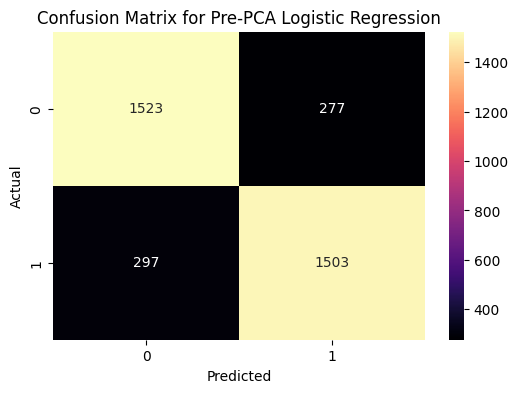

,ModelName,Classifier Score,Cross Validation Mean,Cross Validation Standard Deviation,F1-Score
0,Pre-PCA Logistic Regression,0.840556,0.842686,0.010196,0.839665


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=.2, random_state=42, stratify=y_resampled)
scaler = StandardScaler()
X_train[cols_numeric] = scaler.fit_transform(X_train[cols_numeric])
X_test[cols_numeric] = scaler.transform(X_test[cols_numeric])

clsfrName = "Pre-PCA Logistic Regression"
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(f"Classification Report for Logistic Regression for Testing Set:\n")
print(classification_report(y_test, y_pred))

basic_lr = (clsfrName, classifier)
class_scores_columns = ['ModelName', 'Classifier Score', 'Cross Validation Mean', 'Cross Validation Standard Deviation', 'F1-Score']
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma')
plt.title(f"Confusion Matrix for {clsfrName}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(f'{clsfrName}_Confusion_Matrix.png')
plt.show()
crossVal = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=10)
f1 = f1_score(y_test, y_pred)
basic_lr_scores = pd.DataFrame([[clsfrName, classifier.score(X_test, y_test), crossVal.mean(), crossVal.std(), f1]], columns=class_scores_columns)
display(basic_lr_scores)

## Perform Backwards Elimination to Find the Most Important Variables in the Dataset

In [58]:
def backwardElimination(x, y, sl):
    numVars = len(x[0])
    indices = list(range(numVars))
    for i in range(0, numVars):
        obj_OLS = sm.OLS(y, x).fit()
        maxVar = max(obj_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, len(indices)):
                if (obj_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    indices.pop(j)
                    break
    display(obj_OLS.summary())
    x = x[:, 1:]
    indices.pop(0)
    indices = [i - 1 for i in indices]
    return x, indices

SL = 0.05
X_backe = np.append(arr=np.ones((len(X_resampled),1)), values=X_resampled, axis=1)
X_backe = X_backe.astype('float64')
X_sig = X_backe
X_Modeled, indices = backwardElimination(X_sig, y_resampled, SL)
print(f'Selected Features Indices: {indices}')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     686.1
Date:                Sat, 26 Apr 2025   Prob (F-statistic):               0.00
Time:                        14:57:11   Log-Likelihood:                -7210.3
No. Observations:               17998   AIC:                         1.447e+04
Df Residuals:                   17973   BIC:                         1.467e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3211      0.015     85.457      0.000       1.291       1.351
x1             0.0011      0.000      2.605      0.009       0.000       0.002
x2            -0.0140      0.002     -8.622      0.000      -0.017      -0.011
x3            -0.0913      0.006    -15.385      0.000      -0.103      -0.080
x4            -0.1074      0.006    -19.173      0.000      -0.118      -0.096
x5            -0.2422      0.012    -20.371      0.000      -0.265      -0.219
x6            -0.2255      0.008    -26.614      0.000      -0.242      -0.209
x7            -0.1842      0.007    -26.631      0.000      -0.198      -0.171
x8            -0.0623      0.006    -10.997      0.000      -0.073      -0.051
x9            -0.2002      0.007    -30.285      0.000      -0.213      -0.187
x10           -0.2801      0.009    -29.722      0.000      -0.299      -0.262
x11           -0.3473      0.017    -20.978      0.000      -0.380      -0.315
x12           -0.3624      0.017    -21.642      0.000      -0.395      -0.330
x13           -0.2765      0.010    -28.645      0.000      -0.295      -0.258
x14           -0.1602      0.007    -23.794      0.000      -0.173      -0.147
x15           -0.0616      0.005    -11.290      0.000      -0.072      -0.051
x16           -0.1826      0.012    -15.851      0.000      -0.205      -0.160
x17           -0.1187      0.007    -17.803      0.000      -0.132      -0.106
x18           -0.2076      0.009    -23.911      0.000      -0.225      -0.191
x19           -0.1369      0.006    -23.063      0.000      -0.149      -0.125
x20           -0.1666      0.007    -22.230      0.000      -0.181      -0.152
x21           -0.1191      0.006    -18.822      0.000      -0.132      -0.107
x22           -0.0899      0.006    -16.026      0.000      -0.101      -0.079
x23           -0.1308      0.007    -19.226      0.000      -0.144      -0.118
x24           -0.1241      0.008    -15.492      0.000      -0.140      -0.108
==============================================================================
Omnibus:                      270.514   Durbin-Watson:                   1.494
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              282.542
Skew:                           0.306   Prob(JB):                     4.43e-62
Kurtosis:                       3.041   Cond. No.                         201.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Selected Features Indices: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


## Display the head of the X variable with only the 'important' indices selected

In [59]:
X_resampled = pd.DataFrame(X_resampled, columns=X.columns[indices].to_list())
X_resampled.head()

,Age_at_Marriage,Children_Count,Marriage_Type_Love,Gender_Male,Education_Level_PhD,Education_Level_Postgraduate,Education_Level_School,Caste_Match_Same,Religion_Hindu,Religion_Muslim,Religion_Others,Religion_Sikh,Parental_Approval_Partial,Parental_Approval_Yes,Urban_Rural_Urban,Dowry_Exchanged_Not Disclosed,Dowry_Exchanged_Yes,Marital_Satisfaction_Low,Marital_Satisfaction_Medium,Income_Level_Low,Income_Level_Middle,Spouse_Working_Yes,Inter_Caste_Yes,Inter_Religion_Yes
0,23,5,True,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False
1,28,3,True,False,False,False,True,True,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True
2,39,0,False,True,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False
3,26,0,False,False,False,False,True,False,True,False,False,False,False,True,True,False,True,True,False,False,False,False,True,False
4,32,1,True,False,False,False,False,True,True,False,False,False,True,False,False,False,True,False,True,False,True,False,False,True


## Get the numeric columns in the adjusted dataset

In [60]:
cols_numeric = X_resampled.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numeric Columns:\n{cols_numeric}")

Numeric Columns:
['Age_at_Marriage', 'Children_Count']


## Perform a Test/Train Split Along the Data

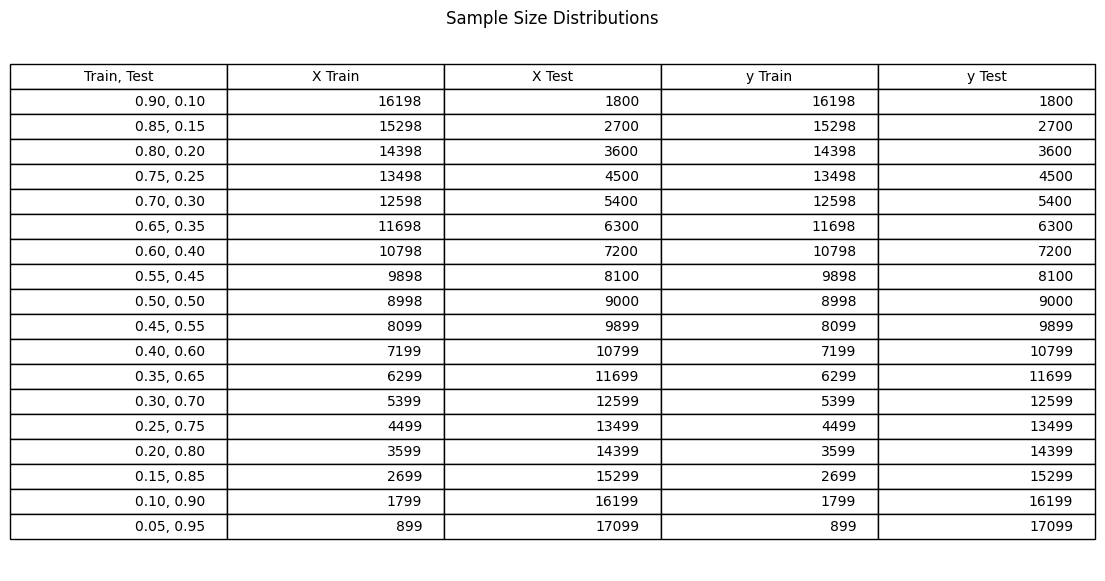

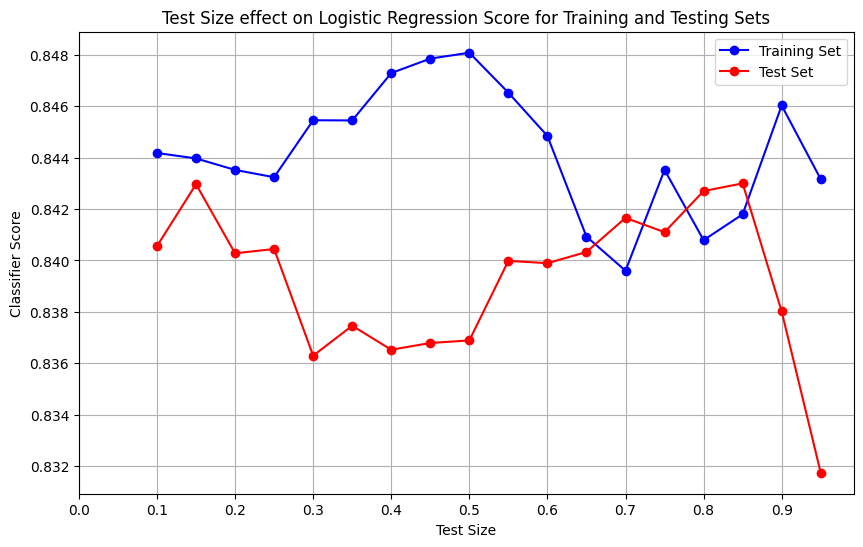

In [61]:
testScores = []
trainScores = []
testSampleSizes = np.arange(0.1, 1.0, 0.05)
tableVals = []
for i in testSampleSizes:
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=i, random_state=42, stratify=y_resampled)

    tableVals.append([f'{1-i:.2f}, {i:.2f}', len(X_train), len(X_test), len(y_train), len(y_test)])

    scaler = StandardScaler()
    X_train[cols_numeric] = scaler.fit_transform(X_train[cols_numeric])
    X_test[cols_numeric] = scaler.transform(X_test[cols_numeric])

    lr = LogisticRegression(random_state=42)
    lr.fit(X_train, y_train)
    trainScores.append(lr.score(X_train, y_train))
    testScores.append(lr.score(X_test, y_test))

tableCols = ['Train, Test', 'X Train', 'X Test', 'y Train', 'y Test']
fig, ax = plt.subplots(figsize=(14,7))
ax.set_axis_off()
table = ax.table(cellText=tableVals, colLabels=tableCols, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
ax.title.set_text("Sample Size Distributions")
plt.savefig('Sample_Size_Distributions.png')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(testSampleSizes, trainScores, marker='o', color='blue', linestyle='-', label='Training Set')
plt.plot(testSampleSizes, testScores, marker='o', color='red', linestyle='-', label='Test Set')
plt.title('Test Size effect on Logistic Regression Score for Training and Testing Sets')
plt.xlabel('Test Size')
plt.ylabel('Classifier Score')
plt.xticks(np.arange(0, 1, .1))
plt.savefig('Dataset_Split_Effect_On_LR_Performance.png')
plt.legend()
plt.grid()
plt.show()

## 0.15 Seems to be the Best

In [62]:
#Train/validation
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.15, random_state=42, stratify=y_resampled)

## Use a Standard Scaler to Scale the Numeric Data

In [63]:
scaler = StandardScaler()
X_train[cols_numeric] = scaler.fit_transform(X_train[cols_numeric])
X_test[cols_numeric] = scaler.transform(X_test[cols_numeric])

print("X Training Set Head:")
display(X_train.head())

print("X Testing Set Head:")
display(X_test.head())

X Training Set Head:


,Age_at_Marriage,Children_Count,Marriage_Type_Love,Gender_Male,Education_Level_PhD,Education_Level_Postgraduate,Education_Level_School,Caste_Match_Same,Religion_Hindu,Religion_Muslim,Religion_Others,Religion_Sikh,Parental_Approval_Partial,Parental_Approval_Yes,Urban_Rural_Urban,Dowry_Exchanged_Not Disclosed,Dowry_Exchanged_Yes,Marital_Satisfaction_Low,Marital_Satisfaction_Medium,Income_Level_Low,Income_Level_Middle,Spouse_Working_Yes,Inter_Caste_Yes,Inter_Religion_Yes
11999,1.358809,-1.399603,False,True,False,False,False,True,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False
10624,0.874834,-1.399603,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False
759,-1.706368,1.591446,False,False,False,False,True,True,True,False,False,False,False,True,True,False,False,False,True,False,True,True,False,False
15295,0.068208,-0.203183,False,True,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
427,0.713509,-0.203183,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False


X Testing Set Head:


,Age_at_Marriage,Children_Count,Marriage_Type_Love,Gender_Male,Education_Level_PhD,Education_Level_Postgraduate,Education_Level_School,Caste_Match_Same,Religion_Hindu,Religion_Muslim,Religion_Others,Religion_Sikh,Parental_Approval_Partial,Parental_Approval_Yes,Urban_Rural_Urban,Dowry_Exchanged_Not Disclosed,Dowry_Exchanged_Yes,Marital_Satisfaction_Low,Marital_Satisfaction_Medium,Income_Level_Low,Income_Level_Middle,Spouse_Working_Yes,Inter_Caste_Yes,Inter_Religion_Yes
7222,-1.222393,-0.801393,True,True,False,False,False,True,True,False,False,False,False,True,True,False,False,False,True,True,False,False,False,True
11027,0.874834,0.395026,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False
78,0.552184,1.591446,False,True,False,False,False,True,True,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False
17457,-1.222393,-1.399603,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
15819,-0.577092,-0.203183,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,True,True,False


## Perform LDA on the Prepped Data

In [73]:
train_scores = []
test_scores = []
upperLimit = len(X_train.columns) - 1
for i in range(1, upperLimit):
    lda = LDA(n_components=i)
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)

    lr = LogisticRegression()
    lr.fit(X_train_lda, y_train)
    train_scores.append(lr.score(X_train_lda, y_train))
    test_scores.append(lr.score(X_test_lda, y_test))


plt.figure(figsize=(10, 6))
plt.plot(range(1, upperLimit), train_scores, marker='o', color='blue', linestyle='-', label='Training Set')
plt.plot(range(1, upperLimit), test_scores, marker='o', color='red', linestyle='-', label='Testing Set')
plt.title('Performance of LDA on Logistic Regression with N Components')
plt.xlabel('Number of Components')
plt.ylabel('Logistic Regression Model Score')
plt.xticks(range(1, upperLimit))
plt.grid()
plt.savefig('LDA_Performance_By_N_Components.png')
plt.legend()
plt.show()

ValueError: n_components cannot be larger than min(n_features, n_classes - 1).

## Use 15 as the Number of Principal Components

In [28]:
pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

## Build a Reusable Method for Training and Testing Models

In [31]:
class_scores = basic_lr_scores.copy()
def ModelTrainFitAndReport(classifier, classifierName, scoresDataFrame):
    classifier.fit(X_train_pca, y_train)
    y_pred = classifier.predict(X_test_pca)
    print(f"Classification Report for {classifierName} for Testing Set:\n")
    print(classification_report(y_test, y_pred))
    crossVal = cross_val_score(estimator=classifier, X=X_train_pca, y=y_train, cv=10)
    f1 = f1_score(y_test, y_pred)
    scoresDataFrame.loc[-1] = [classifierName, classifier.score(X_test_pca, y_test), crossVal.mean(), crossVal.std(), f1]
    scoresDataFrame.index = scoresDataFrame.index + 1
    scoresDataFrame = scoresDataFrame.sort_index()
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='magma')
    plt.title(f"Confusion Matrix for {classifierName}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f'{classifierName}_Confusion_Matrix.png')
    plt.show()
    display(scoresDataFrame)

    return (classifierName, classifier)


## Model Selection

### Logistic Regression

Classification Report for Logistic Regression for Testing Set:

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1350
           1       0.82      0.81      0.81      1350

    accuracy                           0.81      2700
   macro avg       0.81      0.81      0.81      2700
weighted avg       0.81      0.81      0.81      2700



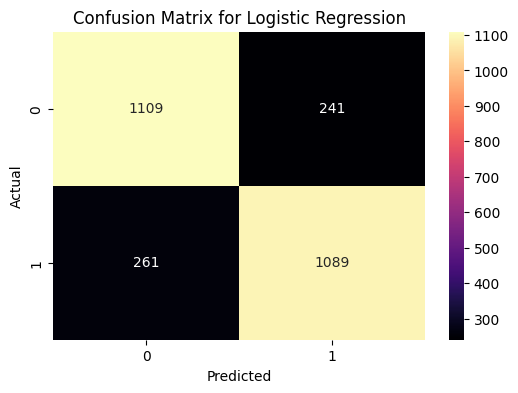

,ModelName,Classifier Score,Cross Validation Mean,Cross Validation Standard Deviation,F1-Score
0,Logistic Regression,0.814074,0.810173,0.013402,0.812687
1,Pre-PCA Logistic Regression,0.840556,0.842686,0.010196,0.839665


In [32]:
logistic_regression = ModelTrainFitAndReport(LogisticRegression(), "Logistic Regression", class_scores)

### Random Forest

Classification Report for Random Forest for Testing Set:

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1350
           1       0.92      0.89      0.90      1350

    accuracy                           0.91      2700
   macro avg       0.91      0.91      0.91      2700
weighted avg       0.91      0.91      0.91      2700



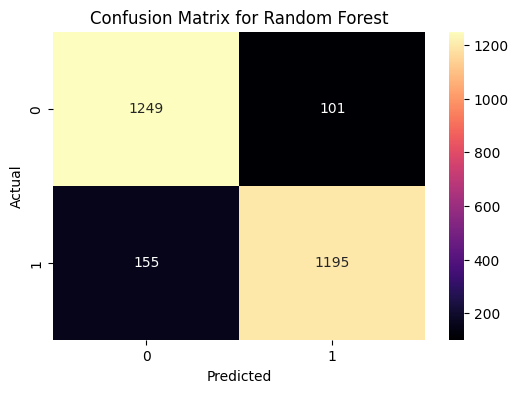

,ModelName,Classifier Score,Cross Validation Mean,Cross Validation Standard Deviation,F1-Score
0,Random Forest,0.905185,0.893974,0.008745,0.903250
1,Logistic Regression,0.814074,0.810173,0.013402,0.812687
2,Pre-PCA Logistic Regression,0.840556,0.842686,0.010196,0.839665


In [33]:
random_forest = ModelTrainFitAndReport(RandomForestClassifier(), "Random Forest", class_scores)

### Support Vector Classifier

#### RBF Kernel

Classification Report for RBF SVM for Testing Set:

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1350
           1       0.88      0.82      0.85      1350

    accuracy                           0.86      2700
   macro avg       0.86      0.86      0.86      2700
weighted avg       0.86      0.86      0.86      2700



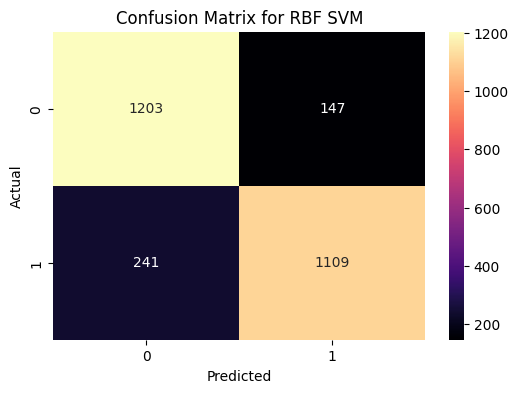

,ModelName,Classifier Score,Cross Validation Mean,Cross Validation Standard Deviation,F1-Score
0,RBF SVM,0.856296,0.848740,0.010638,0.851113
1,Random Forest,0.905185,0.893974,0.008745,0.903250
2,Logistic Regression,0.814074,0.810173,0.013402,0.812687
3,Pre-PCA Logistic Regression,0.840556,0.842686,0.010196,0.839665


In [34]:
rbf_svm = ModelTrainFitAndReport(SVC(kernel='rbf'), "RBF SVM", class_scores)

#### Poly Kernel

Classification Report for Polynomial SVM for Testing Set:

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1350
           1       0.82      0.83      0.83      1350

    accuracy                           0.82      2700
   macro avg       0.82      0.82      0.82      2700
weighted avg       0.82      0.82      0.82      2700



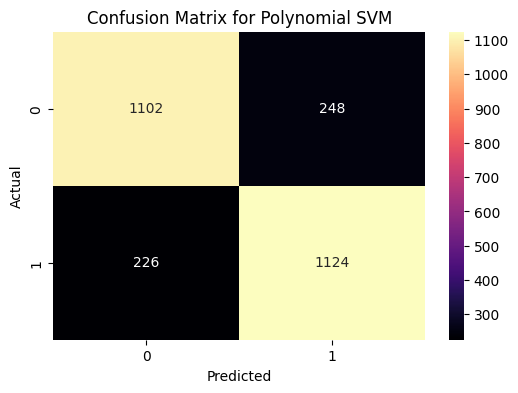

,ModelName,Classifier Score,Cross Validation Mean,Cross Validation Standard Deviation,F1-Score
0,Polynomial SVM,0.824444,0.821546,0.010018,0.825863
1,RBF SVM,0.856296,0.848740,0.010638,0.851113
2,Random Forest,0.905185,0.893974,0.008745,0.903250
3,Logistic Regression,0.814074,0.810173,0.013402,0.812687
4,Pre-PCA Logistic Regression,0.840556,0.842686,0.010196,0.839665


In [35]:
poly_svm = ModelTrainFitAndReport(SVC(kernel='poly'), "Polynomial SVM", class_scores)

### Decision Tree Classifier

Classification Report for Decision Tree for Testing Set:

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1350
           1       0.81      0.88      0.85      1350

    accuracy                           0.84      2700
   macro avg       0.84      0.84      0.84      2700
weighted avg       0.84      0.84      0.84      2700



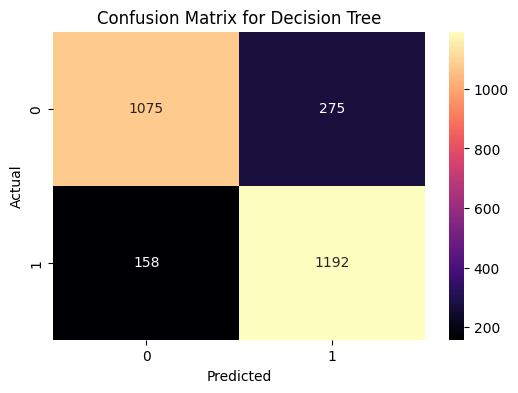

,ModelName,Classifier Score,Cross Validation Mean,Cross Validation Standard Deviation,F1-Score
0,Decision Tree,0.839630,0.834947,0.009884,0.846290
1,Polynomial SVM,0.824444,0.821546,0.010018,0.825863
2,RBF SVM,0.856296,0.848740,0.010638,0.851113
3,Random Forest,0.905185,0.893974,0.008745,0.903250
4,Logistic Regression,0.814074,0.810173,0.013402,0.812687
5,Pre-PCA Logistic Regression,0.840556,0.842686,0.010196,0.839665


In [36]:
decision_tree = ModelTrainFitAndReport(DecisionTreeClassifier(criterion='entropy'), "Decision Tree", class_scores)

### Naive Bayes Classifier

Classification Report for Gaussian Naive Bayes for Testing Set:

              precision    recall  f1-score   support

           0       0.78      0.81      0.80      1350
           1       0.80      0.77      0.79      1350

    accuracy                           0.79      2700
   macro avg       0.79      0.79      0.79      2700
weighted avg       0.79      0.79      0.79      2700



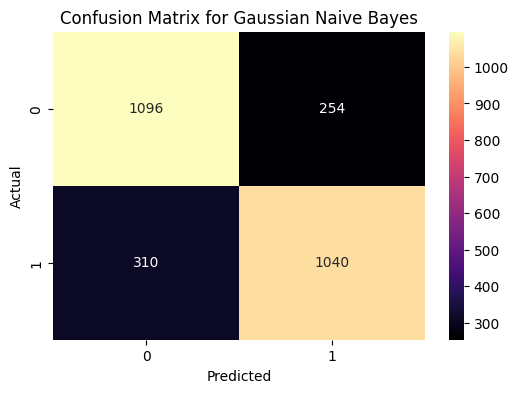

,ModelName,Classifier Score,Cross Validation Mean,Cross Validation Standard Deviation,F1-Score
0,Gaussian Naive Bayes,0.791111,0.787294,0.012071,0.786687
1,Decision Tree,0.839630,0.834947,0.009884,0.846290
2,Polynomial SVM,0.824444,0.821546,0.010018,0.825863
3,RBF SVM,0.856296,0.848740,0.010638,0.851113
4,Random Forest,0.905185,0.893974,0.008745,0.903250
5,Logistic Regression,0.814074,0.810173,0.013402,0.812687
6,Pre-PCA Logistic Regression,0.840556,0.842686,0.010196,0.839665


In [37]:
naive_bayes = ModelTrainFitAndReport(GaussianNB(), "Gaussian Naive Bayes", class_scores)

### Adaptive Boost Classifier

Classification Report for AdaBoost for Testing Set:

              precision    recall  f1-score   support

           0       0.80      0.81      0.81      1350
           1       0.81      0.79      0.80      1350

    accuracy                           0.80      2700
   macro avg       0.80      0.80      0.80      2700
weighted avg       0.80      0.80      0.80      2700



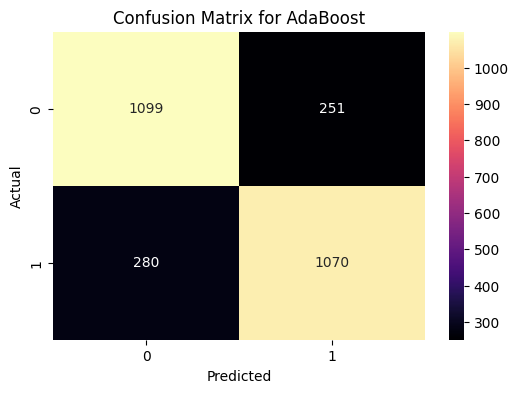

,ModelName,Classifier Score,Cross Validation Mean,Cross Validation Standard Deviation,F1-Score
0,AdaBoost,0.803333,0.801022,0.014308,0.801198
1,Gaussian Naive Bayes,0.791111,0.787294,0.012071,0.786687
2,Decision Tree,0.839630,0.834947,0.009884,0.846290
3,Polynomial SVM,0.824444,0.821546,0.010018,0.825863
4,RBF SVM,0.856296,0.848740,0.010638,0.851113
5,Random Forest,0.905185,0.893974,0.008745,0.903250
6,Logistic Regression,0.814074,0.810173,0.013402,0.812687
7,Pre-PCA Logistic Regression,0.840556,0.842686,0.010196,0.839665


In [38]:
ada_boost = ModelTrainFitAndReport(AdaBoostClassifier(), "AdaBoost", class_scores)

### Gradient Boost Classifier

Classification Report for Gradient Boost for Testing Set:

              precision    recall  f1-score   support

           0       0.82      0.87      0.85      1350
           1       0.86      0.81      0.84      1350

    accuracy                           0.84      2700
   macro avg       0.84      0.84      0.84      2700
weighted avg       0.84      0.84      0.84      2700



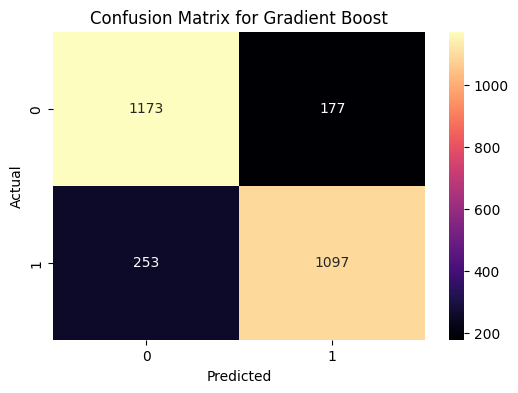

,ModelName,Classifier Score,Cross Validation Mean,Cross Validation Standard Deviation,F1-Score
0,Gradient Boost,0.840741,0.832464,0.012809,0.836128
1,AdaBoost,0.803333,0.801022,0.014308,0.801198
2,Gaussian Naive Bayes,0.791111,0.787294,0.012071,0.786687
3,Decision Tree,0.839630,0.834947,0.009884,0.846290
4,Polynomial SVM,0.824444,0.821546,0.010018,0.825863
5,RBF SVM,0.856296,0.848740,0.010638,0.851113
6,Random Forest,0.905185,0.893974,0.008745,0.903250
7,Logistic Regression,0.814074,0.810173,0.013402,0.812687
8,Pre-PCA Logistic Regression,0.840556,0.842686,0.010196,0.839665


In [39]:
gradient_boost = ModelTrainFitAndReport(GradientBoostingClassifier(), "Gradient Boost", class_scores)

### XGBoost Classifier

Classification Report for XGBoost for Testing Set:

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      1350
           1       0.89      0.88      0.88      1350

    accuracy                           0.88      2700
   macro avg       0.88      0.88      0.88      2700
weighted avg       0.88      0.88      0.88      2700



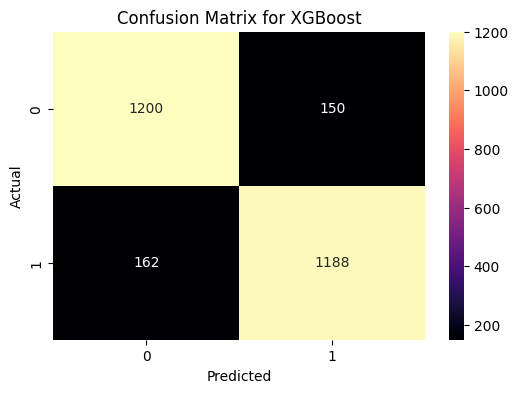

,ModelName,Classifier Score,Cross Validation Mean,Cross Validation Standard Deviation,F1-Score
0,XGBoost,0.884444,0.879855,0.010313,0.883929
1,Gradient Boost,0.840741,0.832464,0.012809,0.836128
2,AdaBoost,0.803333,0.801022,0.014308,0.801198
3,Gaussian Naive Bayes,0.791111,0.787294,0.012071,0.786687
4,Decision Tree,0.839630,0.834947,0.009884,0.846290
5,Polynomial SVM,0.824444,0.821546,0.010018,0.825863
6,RBF SVM,0.856296,0.848740,0.010638,0.851113
7,Random Forest,0.905185,0.893974,0.008745,0.903250
8,Logistic Regression,0.814074,0.810173,0.013402,0.812687
9,Pre-PCA Logistic Regression,0.840556,0.842686,0.010196,0.839665


In [40]:
xgboost = ModelTrainFitAndReport(XGBClassifier(), "XGBoost", class_scores)

### $k$-Nearest Neighbors Classifier

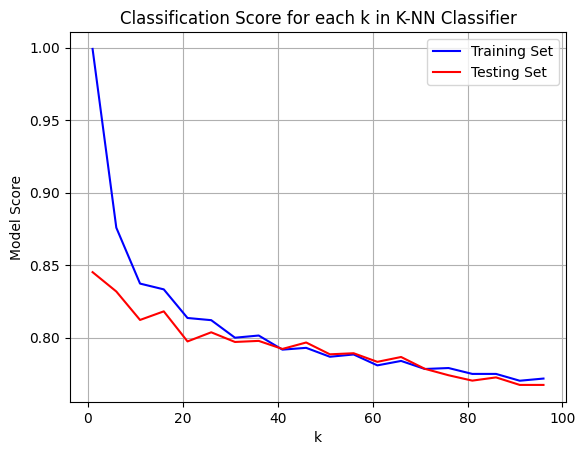

In [41]:
train_scores = []
test_scores = []
ks = np.arange(1, 100, 5)
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_pca, y_train)
    train_scores.append(knn.score(X_train_pca, y_train))
    test_scores.append(knn.score(X_test_pca, y_test))

plt.plot(ks, train_scores, color='blue', label='Training Set')
plt.plot(ks, test_scores, color='red', label='Testing Set')
plt.xlabel('k')
plt.ylabel('Model Score')
plt.title('Classification Score for each k in K-NN Classifier')
plt.grid(True)
plt.legend()
plt.savefig('KNN_Scores.png')
plt.show()

#### Use best $k$ value for $k$-NN

Classification Report for k-NN for Testing Set:

              precision    recall  f1-score   support

           0       0.91      0.77      0.83      1350
           1       0.80      0.93      0.86      1350

    accuracy                           0.85      2700
   macro avg       0.85      0.85      0.84      2700
weighted avg       0.85      0.85      0.84      2700



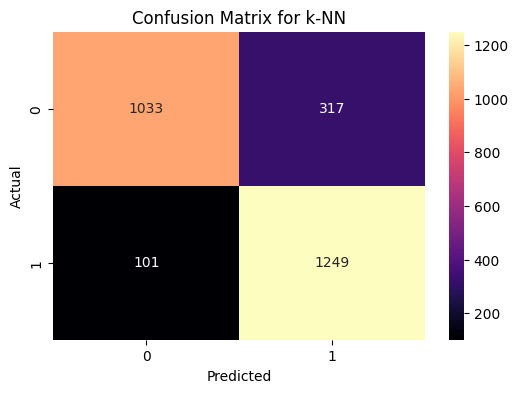

,ModelName,Classifier Score,Cross Validation Mean,Cross Validation Standard Deviation,F1-Score
0,k-NN,0.845185,0.838803,0.010944,0.856653
1,XGBoost,0.884444,0.879855,0.010313,0.883929
2,Gradient Boost,0.840741,0.832464,0.012809,0.836128
3,AdaBoost,0.803333,0.801022,0.014308,0.801198
4,Gaussian Naive Bayes,0.791111,0.787294,0.012071,0.786687
5,Decision Tree,0.839630,0.834947,0.009884,0.846290
6,Polynomial SVM,0.824444,0.821546,0.010018,0.825863
7,RBF SVM,0.856296,0.848740,0.010638,0.851113
8,Random Forest,0.905185,0.893974,0.008745,0.903250
9,Logistic Regression,0.814074,0.810173,0.013402,0.812687


In [42]:
knn = ModelTrainFitAndReport(KNeighborsClassifier(n_neighbors=1), "k-NN", class_scores)

### Voting Classifier

Classification Report for Voting (Hard) for Testing Set:

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1350
           1       0.88      0.85      0.86      1350

    accuracy                           0.86      2700
   macro avg       0.86      0.86      0.86      2700
weighted avg       0.86      0.86      0.86      2700



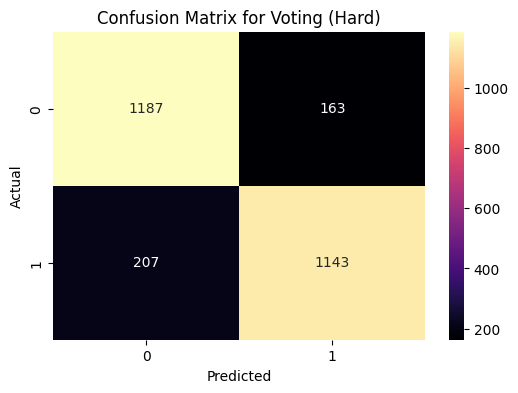

,ModelName,Classifier Score,Cross Validation Mean,Cross Validation Standard Deviation,F1-Score
0,Voting (Hard),0.862963,0.852008,0.012099,0.860693
1,k-NN,0.845185,0.838803,0.010944,0.856653
2,XGBoost,0.884444,0.879855,0.010313,0.883929
3,Gradient Boost,0.840741,0.832464,0.012809,0.836128
4,AdaBoost,0.803333,0.801022,0.014308,0.801198
5,Gaussian Naive Bayes,0.791111,0.787294,0.012071,0.786687
6,Decision Tree,0.839630,0.834947,0.009884,0.846290
7,Polynomial SVM,0.824444,0.821546,0.010018,0.825863
8,RBF SVM,0.856296,0.848740,0.010638,0.851113
9,Random Forest,0.905185,0.893974,0.008745,0.903250


In [43]:
classifiers = [basic_lr, logistic_regression, random_forest, rbf_svm, poly_svm, decision_tree, naive_bayes, ada_boost, gradient_boost, xgboost, knn]
voting_classifier = ModelTrainFitAndReport(VotingClassifier(estimators=classifiers, voting='hard'), "Voting (Hard)", class_scores)

## Display Model Performance Metrics of Each Model

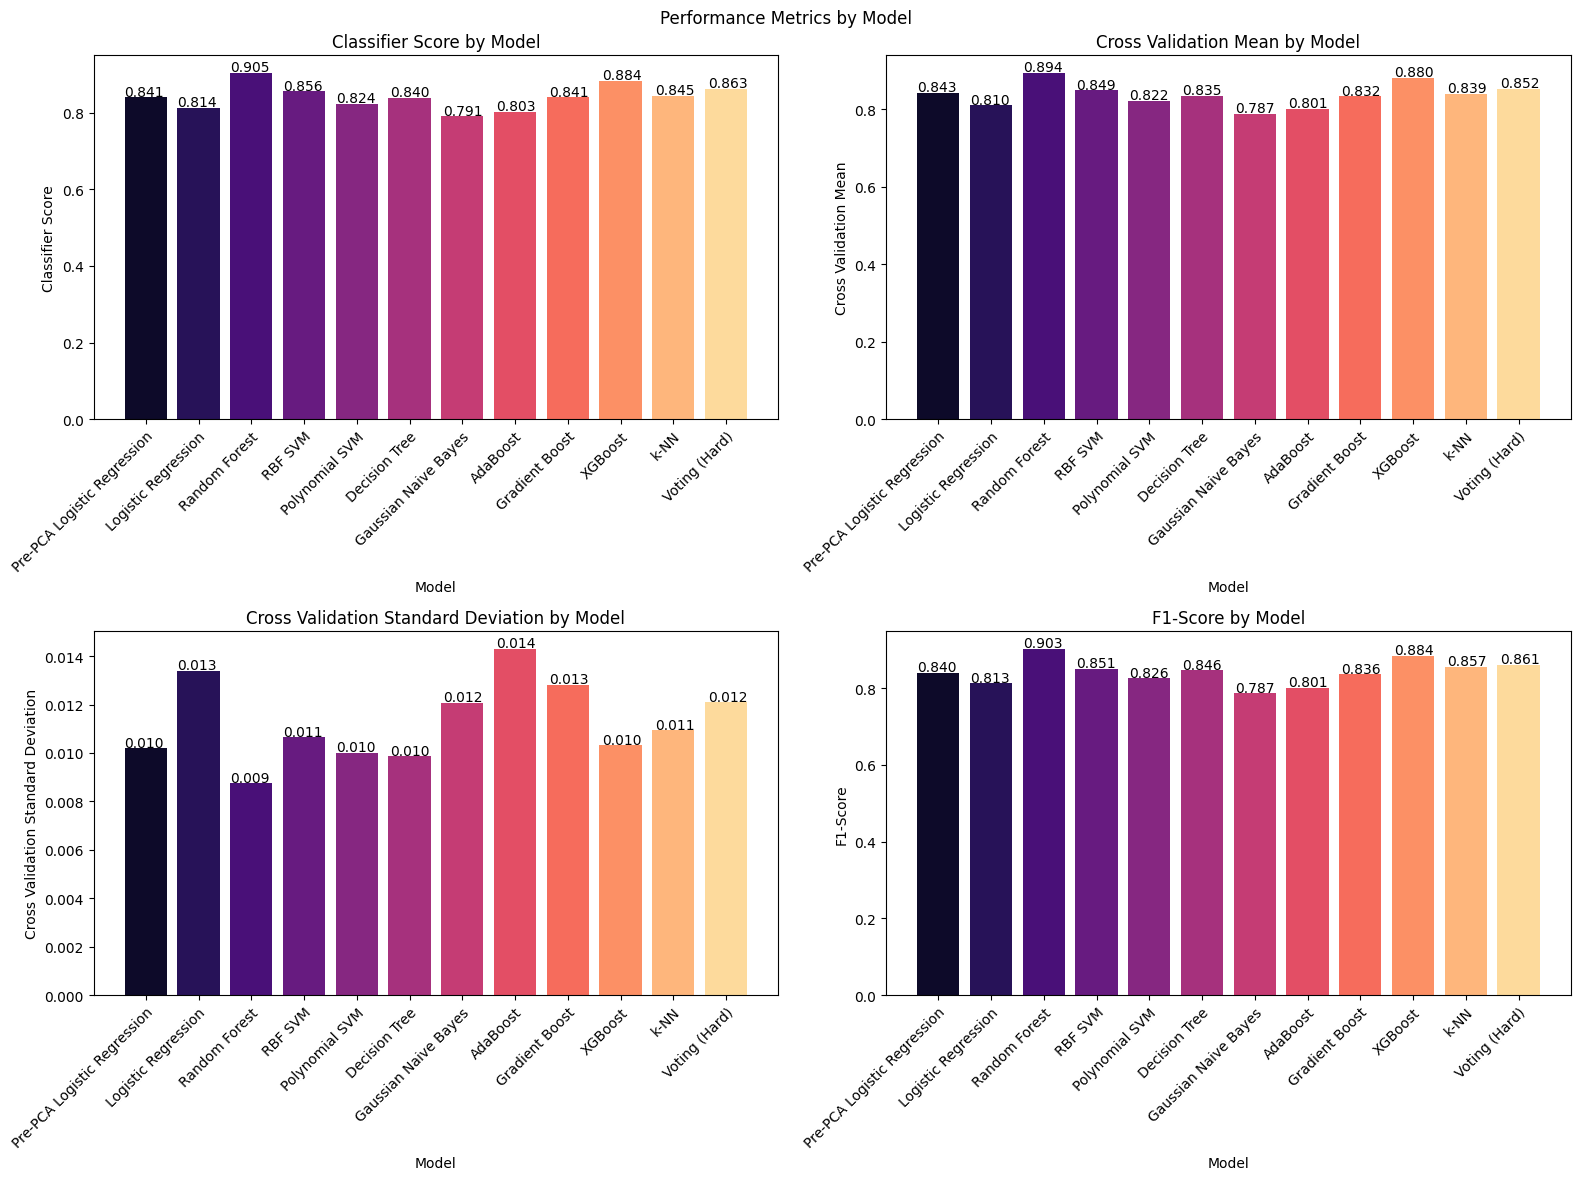

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
fig.suptitle('Performance Metrics by Model')
axes = axes.flatten()
for i in range(1, 5):
    ax = axes[i - 1]
    colors = sns.color_palette('magma', len(class_scores['ModelName']))
    ax.bar(class_scores['ModelName'], class_scores.iloc[:, i], color=colors)
    ax.set_ylabel(class_scores.columns[i])
    ax.set_xlabel('Model')
    ax.set_title(f'{class_scores.columns[i]} by Model')
    ax.set_xticks(np.arange(len(class_scores['ModelName'])))
    ax.set_xticklabels(class_scores['ModelName'], rotation=45, ha='right', rotation_mode='anchor')
    #ax.tick_params(axis='x', labelrotation=45)
    for p in ax.patches:
      ax.annotate(f'{p.get_height():.3f}', (p.get_x() * 1.005, p.get_height() * 1.005))
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted()).expanded(1.25, 1.25)
    fig.savefig(f'{col.replace(" ", "_")}_by_Model.png', bbox_inches=extent)
plt.tight_layout()
plt.savefig('All_Model_Metrics.png')
plt.show()

## Test With New Data

In [45]:
new_data = pd.DataFrame([[32, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]], columns=X_resampled.columns)
new_data[cols_numeric] = scaler.transform(new_data[cols_numeric])
new_data = pca.transform(new_data)

# make a prediction
y_pred = voting_classifier[1].predict(new_data)

result = ""
if y_pred[0] == 1:
    result = "Will Divorce"
else:
    result = "Will Not Divorce"

print(f"Divorce Status Prediction: {result}")

Divorce Status Prediction: Will Not Divorce
